# Part 1

**Question:** Are vaccination rates responsive to the rate of a COVID-19 outbreak?

**Overall Approach:** We compare covid case rates to vaccination rates

**Analysis Methodologies:**
- We measure the correlation between each observation’s case growth and vaccination rate
- We then split these observations on different variables of interest (political leaning, Social Vulnerability Index)




Step 1. Import libraries, data, variables, and functions

In [1]:
from libraries import * # Import libraries from libraries.py
from import_data import * # Import data from import_data.py
from global_variables import * # Import global variables from global_variables.py
from plotting_functions import * # Import plotting functions from plotting_functions.py

# Read in output data from cleaning script. Set date to datetime dtype
df_joined_cases = pd.read_csv(os.getcwd().split('API-201Z')[0] + 'API-201Z/Data Sources/cleaned_joined_states.csv')
df_joined_cases['date'] = pd.to_datetime(df_joined_cases['date'])


First we look at case rates nationwide to find a time window of interest

<AxesSubplot:xlabel='date', ylabel='WoW_%_cases'>

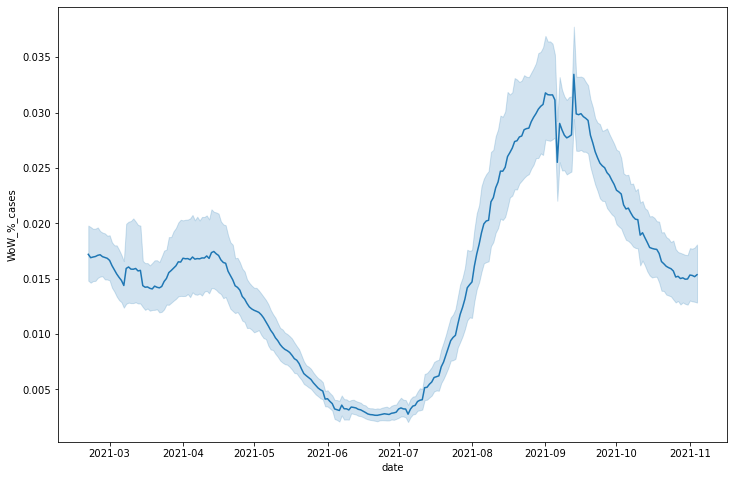

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(
    data=df_joined_cases,
    x='date',
    y='WoW_%_cases'
)

We select July 1st through September 1st as the best timeframe to analyze to answer our research question for the following reasons:
1. By July, virtually all remaining unvaccinated people can be considered 'vaccine hesitant' given that they've had ample time to receive the vaccine after eligibility opened to all adults in all states, and earlier supply chain & logistics issues were resolved. 
2. Cases were increasing at a rapid rate nationwide during this time period (the 4th Wave). Although the 4th Wave continues past September 1st, we find there's a different relationship between case rate and vaccination rate when cases are increasing vs decreasing. We'll analyze the downslope of the 4th Wave separately at the end of this report

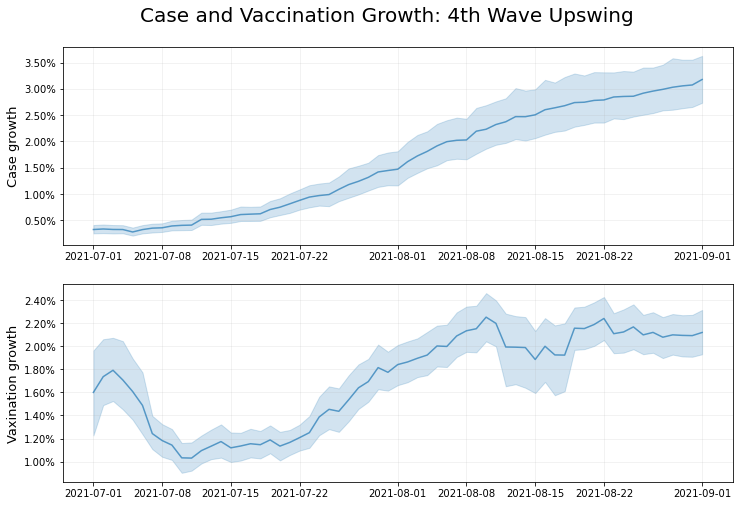

In [3]:
case_and_vax_plot(
    data=df_joined_cases, 
    hue_col=None,
    hue_levels={"Total":"gray"},
    title='Case and Vaccination Growth: 4th Wave Upswing', 
    start="2021-07-01", 
    end="2021-09-01"
    )

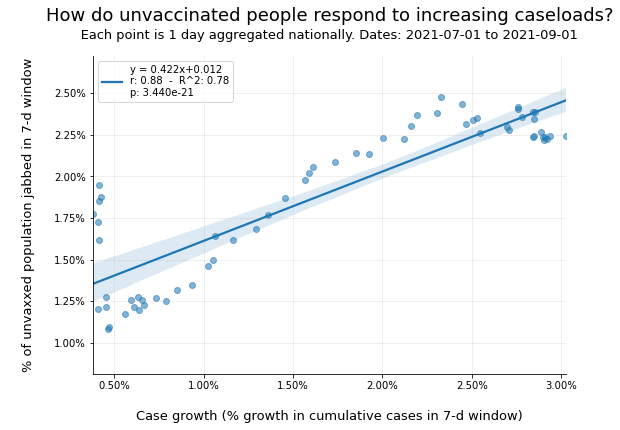

In [74]:
# Cases rising date window no split
agg_lm(
    data=df_joined_cases,
    groupby=None,
    hue_levels={"Total":'gray'},    
    suptitle='Each point is 1 day aggregated nationally',
    start="2021-07-01",
    end="2021-09-01"
)[1]

In [1]:
case_and_vax_plot(
    data=df_joined_cases, 
    hue_col='2020 Election Winner', 
    hue_levels={'Democrat':'blue', 'Republican':'red'}, 
    title='Case and Vaccination Growth: 4th Wave Upswing', 
    start="2021-07-01", 
    end="2021-09-01"
    )

NameError: name 'case_and_vax_plot' is not defined

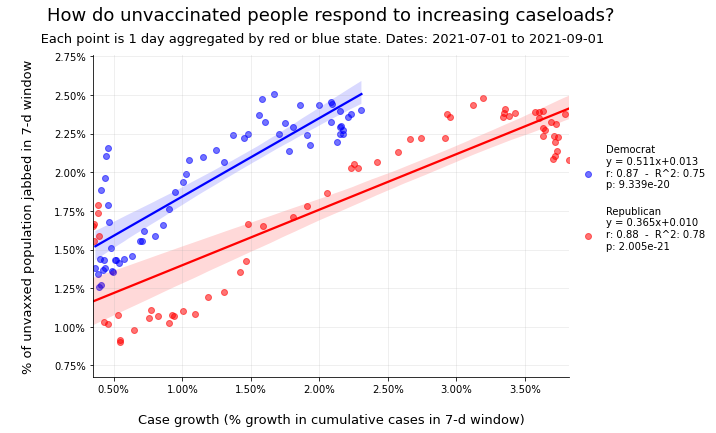

In [77]:
# Cases rising date window split on party
agg_lm(
    data=df_joined_cases,
    groupby='2020 Election Winner',
    hue_levels={'Democrat':'blue', 'Republican':'red'},
    suptitle='Each point is 1 day aggregated by red or blue state',
    start="2021-07-01",
    end="2021-09-01"
)[1]

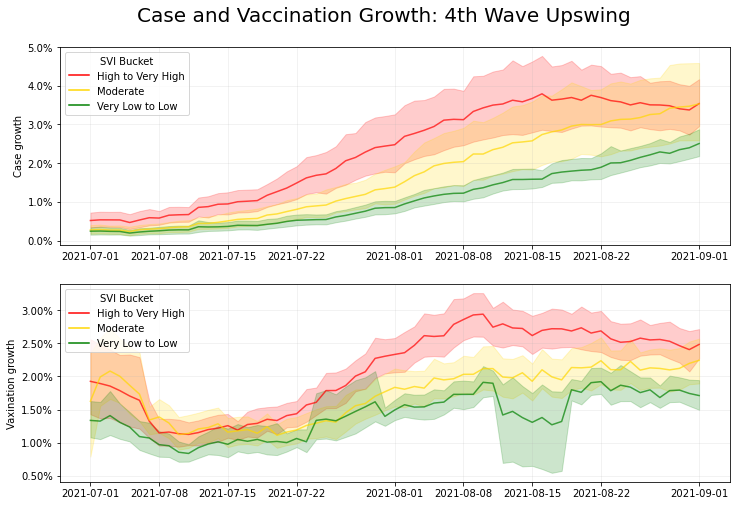

In [13]:
case_and_vax_plot(
    data=df_joined_cases, 
    hue_col='SVI Bucket', 
    hue_levels={'High to Very High':'red', 'Moderate':'gold', 'Very Low to Low':'green'}, 
    title='Case and Vaccination Growth: 4th Wave Upswing', 
    start="2021-07-01", 
    end="2021-09-01"
    )

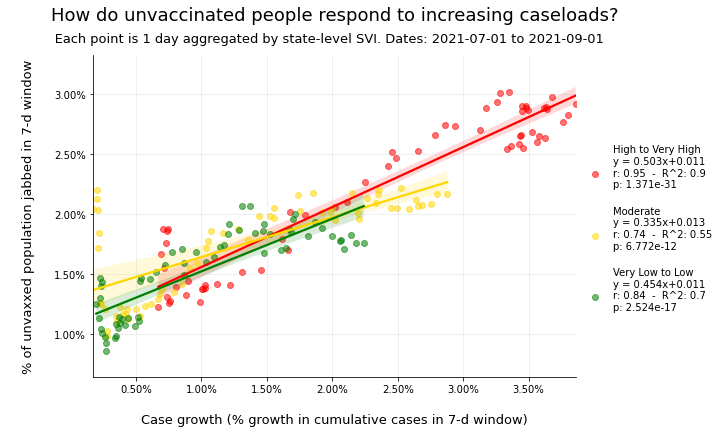

In [80]:
# Cases rising date window split on svi
agg_lm(
    data=df_joined_cases,
    groupby='SVI Bucket',
    hue_levels={'High to Very High':'red', 'Moderate':'gold', 'Very Low to Low':'green'},
    suptitle='Each point is 1 day aggregated by state-level SVI',
    start="2021-07-01",
    end="2021-09-01"
)[1]

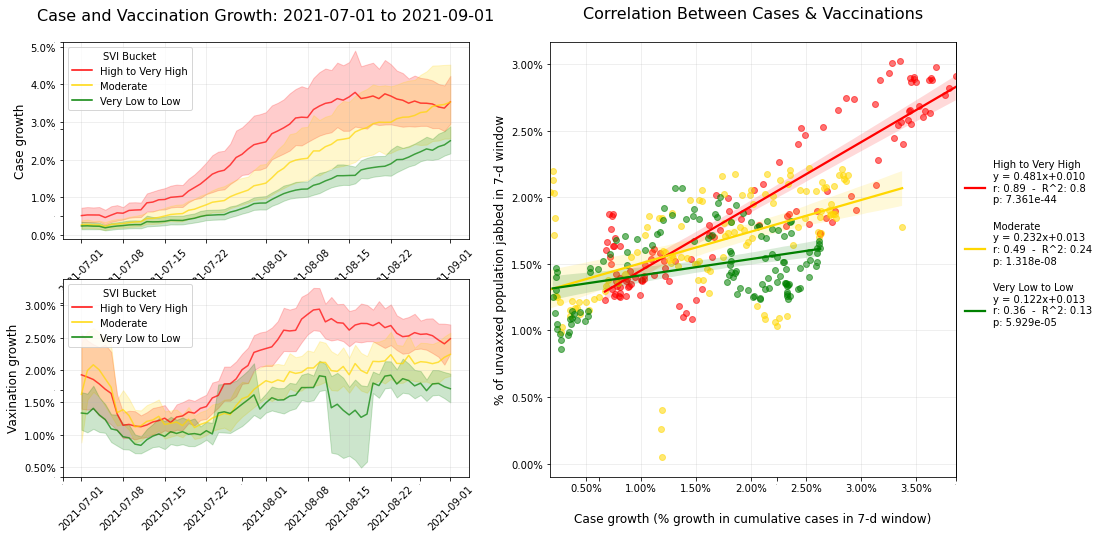

In [2]:
vax_cases_and_correlation(
    data=df_joined_cases, 
    groupby='SVI Bucket', 
    hue_levels={'High to Very High':'red', 'Moderate':'gold', 'Very Low to Low':'green'},
    start="2021-07-01", 
    end="2021-09-01"
) 
